In [28]:
import pandas as pd
import xarray as xr
import geopandas as gp
import regionmask
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xesmf as xe

## Step 1: Read data

In [2]:
infile = '/g/data/xv83/dbi599/treasury/ffdi_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_19500101-20101231.nc'

In [3]:
ds = xr.open_dataset(infile)

In [4]:
ds

<xarray.Dataset> Size: 6GB
Dimensions:  (lat: 145, lon: 192, time: 55152)
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 441kB 1950-01-01T12:00:00 ... 2100-12-31T1...
Data variables:
    FFDI     (lat, lon, time) float32 6GB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  21915.0
    cmor_version:           3.4.0
    ...                     ...
    table_info:             Creation Date:(30 April 2019) MD5:e14f55f257cceaf...
    title:                  ACCESS-ESM1-5 output prepared for CMIP6
    tracking_id:            hdl:21.14100/4553f1df-b8f3-4181-aca8-d617e2bee527
    variable_id:            FFDI
    variant_label:          r1i1p1f1
    version:                v20191115

In [5]:
location_name = 'Adelaide'
lat = -34.92
lon = 138.62

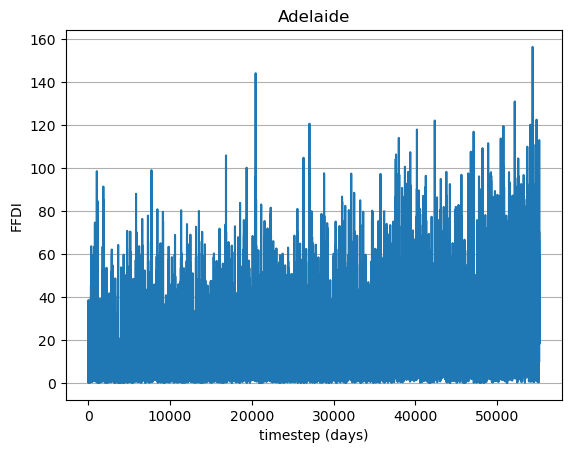

In [6]:
ds_point = ds.sel({'lat': lat, 'lon': lon}, method='nearest')
#ds_point['FFDI'].plot()
plt.plot(ds_point['FFDI'].values)
plt.ylabel('FFDI')
plt.xlabel('timestep (days)')
plt.title(location_name)
plt.grid(axis='y')
plt.show()

### Step 1a: FFDIgt99p

In [7]:
FFDI99p = ds['FFDI'].sel(time=slice('1950-01-01', '2014-12-31')).quantile(0.99, dim='time')
FFDIgt99p = ds['FFDI'] > FFDI99p
FFDIgt99p = FFDIgt99p.resample({'time': 'YE'}).sum('time', keep_attrs=True)
FFDIgt99p.name = 'FFDIgt99p'

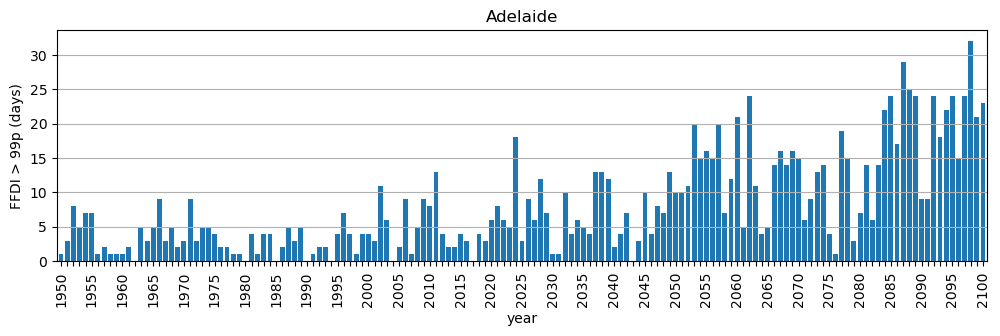

In [8]:
FFDIgt99p_point = FFDIgt99p.sel({'lat': lat, 'lon': lon}, method='nearest')
FFDIgt99p_point_ds = FFDIgt99p_point.to_series()
FFDIgt99p_point_ds.index = FFDIgt99p_point_ds.index.year
ax = FFDIgt99p_point_ds.plot.bar(figsize=[12, 3], width=0.8)
ax.set_ylabel('FFDI > 99p (days)')
ax.set_xlabel('year')
ax.set_title(location_name)
plt.grid(axis='y')
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)
plt.show()

### Step 1b: FFDIx

In [9]:
FFDIx = ds['FFDI'].resample({'time': 'YE'}).max('time', keep_attrs=True)
FFDIx.name = 'FFDIx'
FFDIx = FFDIx.compute()

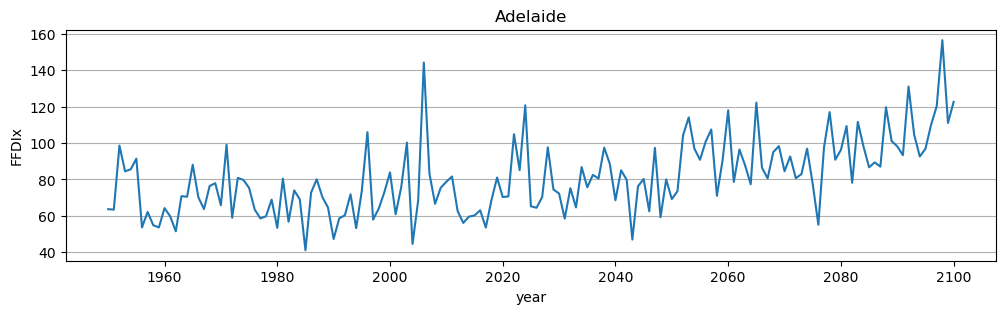

In [10]:
FFDIx_point = FFDIx.sel({'lat': lat, 'lon': lon}, method='nearest')
FFDIx_point_ds = FFDIx_point.to_series()
FFDIx_point_ds.index = FFDIx_point_ds.index.year
ax = FFDIx_point_ds.plot.line(figsize=[12, 3])
ax.set_ylabel('FFDIx')
ax.set_xlabel('year')
ax.set_title(location_name)
plt.grid(axis='y')
plt.show()

In [11]:
#ffdix_clim = ffdix.sel(time=slice('1950-01-01', '2014-12-31')).mean('time', keep_attrs=True)
#ffdix_anomaly = ffdix - ffdix_clim
#ffdix_anomaly_point = ffdix_anomaly.sel({'lat': lat, 'lon': lon}, method='nearest')
#ffdix_anomaly_point.plot()

## Step 2: Read shapefiles

In [12]:
states_gp = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/aus_states_territories/aus_states_territories.shp')

In [13]:
states_gp = states_gp.drop(columns=['AREASQKM21', 'LOCI_URI21'])

In [14]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,Australian Capital Territory,ACT,"POLYGON ((149.06239 -35.1591, 149.09134 -35.14..."
8,Other Territories,OT,"MULTIPOLYGON (((167.94747 -29.12757, 167.94748..."


We're working with a coarse resolution model with grid cells much larger than the ACT and other territories, so we'll leave those out:

In [15]:
states_gp = states_gp[:-2]

In [16]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."


In [17]:
aus_gp = states_gp.dissolve()
aus_gp['STE_NAME21'] = 'Australia'
aus_gp['ABBREV'] = 'AUS'

In [18]:
aus_gp

,geometry,STE_NAME21,ABBREV
0,"MULTIPOLYGON (((113.96119 -28.986, 113.96137 -...",Australia,AUS


In [19]:
states_gp = pd.concat([states_gp, aus_gp], ignore_index=True)

In [20]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,Australia,AUS,"MULTIPOLYGON (((113.96119 -28.986, 113.96137 -..."


We now need to turn our geopandas GeoDataFrame into a regionmask Regions object:

In [21]:
type(states_gp)

geopandas.geodataframe.GeoDataFrame

In [22]:
states_regions = regionmask.from_geopandas(
    states_gp,
    names="STE_NAME21",
    abbrevs="ABBREV",
    name="states",
)

In [23]:
type(states_regions)

regionmask.core.regions.Regions

In [24]:
print(states_regions)

<regionmask.Regions 'states'>
overlap:  None

Regions:
0 NSW    New South Wales
1 VIC           Victoria
2 QLD         Queensland
3  SA    South Australia
4  WA  Western Australia
5 TAS           Tasmania
6  NT Northern Territory
7 AUS          Australia

[8 regions]


## Step 3: Create a mask

We can use the `mask_3D_frac_approx` method to calculate the fraction of each grid cell that overlaps with each shape:

In [25]:
frac = states_regions.mask_3D_frac_approx(FFDIx)

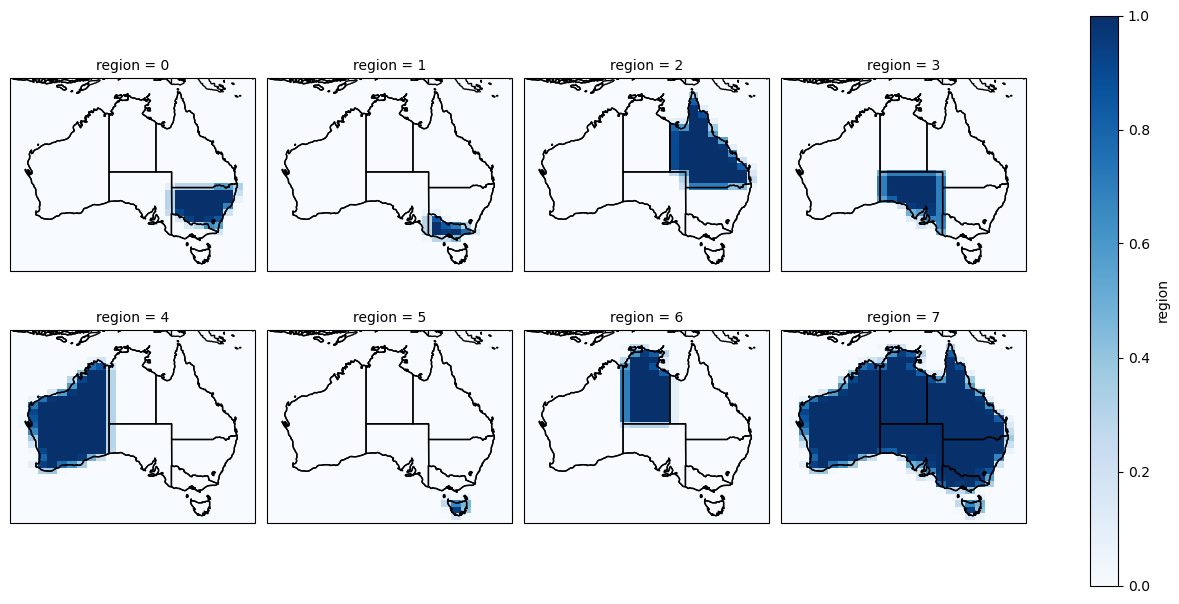

In [53]:
fg = frac.plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col="region",
    col_wrap=4,
    transform=ccrs.PlateCarree(),
    cmap='Blues',
)
for ax in fg.axs.flatten():
    ax.coastlines()
    ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)
plt.show()

In [27]:
def xesmf_regrid(ds, ds_grid, variable):
    """Regrid data using xesmf.
    
    Parameters
    ----------
    ds : xarray Dataset
        Dataset to be regridded
    ds_grid : xarray Dataset
        Dataset containing target horizontal grid
    variable : str
        Variable to restore attributes for
    
    Returns
    -------
    ds : xarray Dataset
    
    """
    
    global_attrs = ds.attrs
    var_attrs = ds[variable].attrs
    regridder = xe.Regridder(ds, ds_grid, 'nearest_s2d')
    ds = regridder(ds)
    ds.attrs = global_attrs
    ds[variable].attrs = var_attrs

    return ds

In [29]:
ds_koppen_1p0 = xr.open_dataset('koppen_geiger_1p0_1991-2020.nc')

In [30]:
ds_koppen = xesmf_regrid(ds_koppen_1p0, frac, variable='kg_class')
ds_koppen = ds_koppen.compute()

In [50]:
arid = (ds_koppen['kg_class'] > 3.5) & (ds_koppen['kg_class'] < 7.5)

In [51]:
frac_masked = ~arid * frac

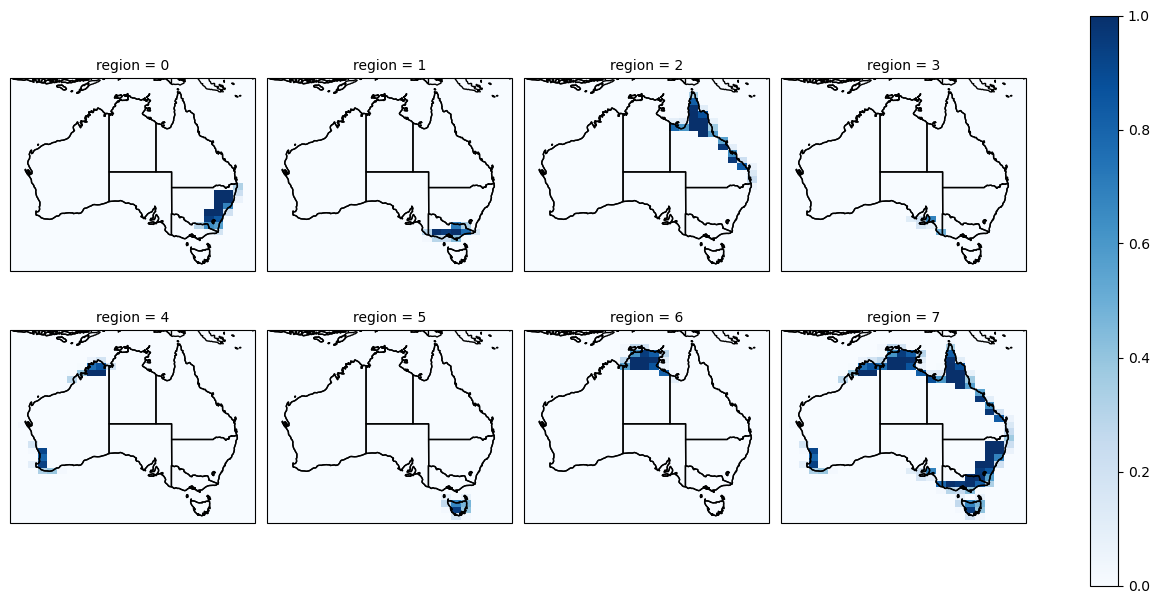

In [52]:
fg = frac_masked.plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col="region",
    col_wrap=4,
    transform=ccrs.PlateCarree(),
    cmap='Blues',
)
for ax in fg.axs.flatten():
    ax.coastlines()
    ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)
plt.show()

## Step 4: Calculate a (weighted) regional mean

In [54]:
weights = np.cos(np.deg2rad(FFDIx['lat']))

The most accurate spatial mean method is to multiply `weights` by the fractional overlap (`frac`) that we calculated earlier. That will ensure that an appropriate fractional value of the grid cells that are on the edge of the state/territory get included in the weighted average:

### Step 4a: FFDIgt99p

In [55]:
FFDIgt99p_spatial_means = FFDIgt99p.weighted(frac_masked * weights).mean(dim=("lat", "lon"))

In [56]:
FFDIgt99p_df = FFDIgt99p_spatial_means.to_pandas()
FFDIgt99p_df.columns = FFDIgt99p_spatial_means['abbrevs']
FFDIgt99p_df.index = FFDIgt99p_df.index.year
FFDIgt99p_df = FFDIgt99p_df.round(decimals=2)

In [57]:
FFDIgt99p_df

,NSW,VIC,QLD,SA,WA,TAS,NT,AUS
time,,,,,,,,
1950,0.98,0.36,1.39,1.39,0.51,1.20,0.17,0.83
1951,1.85,1.29,3.59,1.91,5.69,1.25,5.41,3.57
1952,9.99,6.89,5.33,5.49,8.51,1.40,6.02,6.80
1953,8.50,12.37,1.24,6.11,2.97,5.26,0.23,4.02
1954,15.86,7.78,5.90,5.67,3.02,0.91,5.37,7.22
...,...,...,...,...,...,...,...,...
2096,19.31,5.52,10.14,11.04,10.81,23.37,14.63,13.06
2097,33.06,23.50,17.84,16.50,11.50,25.57,14.43,19.96
2098,22.50,26.12,11.72,23.93,17.54,40.78,9.57,17.15


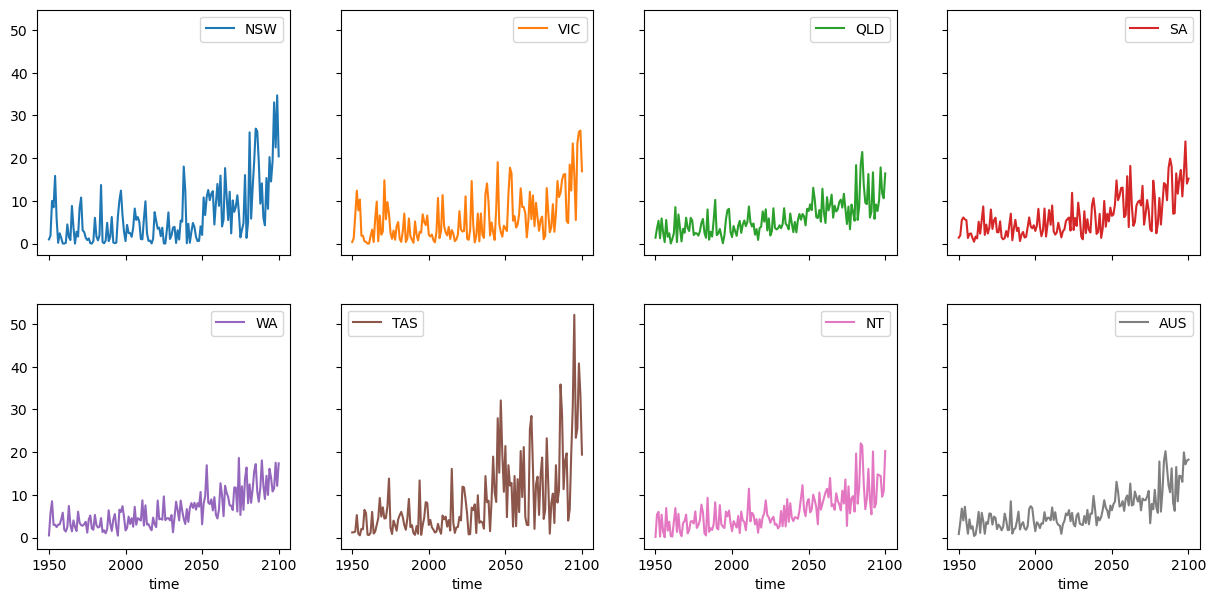

In [58]:
FFDIgt99p_df.plot(
    figsize=[15, 7],
    subplots=True,
    layout=[2,4],
    sharey=True,
)
plt.show()

In [59]:
FFDIgt99p_outfile = '/g/data/xv83/dbi599/treasury/FFDIgt99p_yr_ACCESS-ESM1-5_ssp370_r1i1p1f1_aus-states_1950-2100.csv'

In [60]:
FFDIgt99p_df.to_csv(FFDIgt99p_outfile)

### Step 4b: FFDIx

In [61]:
FFDIx_spatial_means = FFDIx.weighted(frac_masked * weights).mean(dim=("lat", "lon"))

In [62]:
FFDIx_df = FFDIx_spatial_means.to_pandas()
FFDIx_df.columns = FFDIx_spatial_means['abbrevs']
FFDIx_df.index = FFDIx_df.index.year
FFDIx_df = FFDIx_df.round(decimals=1)

In [63]:
FFDIx_df

,NSW,VIC,QLD,SA,WA,TAS,NT,AUS
time,,,,,,,,
1950,33.8,21.6,32.0,35.6,42.8,8.4,38.3,33.3
1951,38.5,30.0,34.2,34.8,56.7,7.7,50.2,40.0
1952,48.2,41.6,38.3,54.9,63.3,7.1,58.6,47.3
1953,49.5,47.5,30.5,50.2,52.2,9.4,41.0,40.6
1954,57.1,52.6,40.6,46.4,55.3,6.7,54.7,48.5
...,...,...,...,...,...,...,...,...
2096,66.1,42.7,44.9,59.3,69.1,11.3,63.5,54.9
2097,68.6,57.6,52.0,70.1,62.9,12.0,64.5,58.5
2098,63.3,56.5,42.2,82.7,73.3,13.6,65.6,56.6


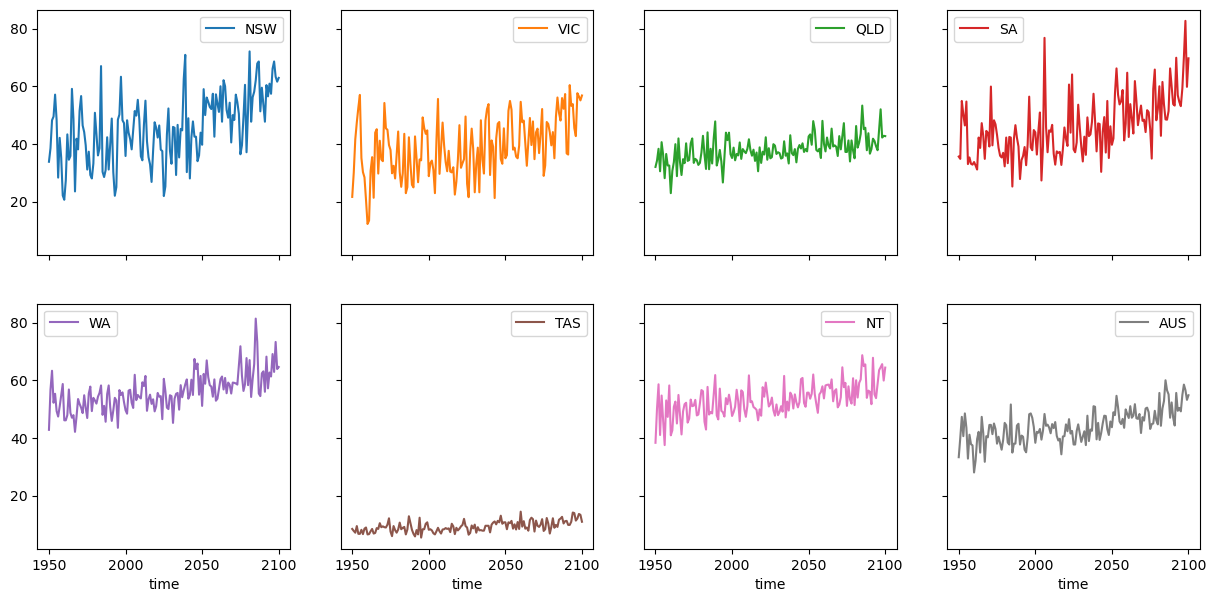

In [64]:
FFDIx_df.plot(
    figsize=[15, 7],
    subplots=True,
    layout=[2,4],
    sharey=True,
)
plt.show()

In [65]:
FFDIx_outfile = '/g/data/xv83/dbi599/treasury/FFDIx_yr_ACCESS-ESM1-5_ssp370_r1i1p1f1_aus-states_1950-2100.csv'

In [66]:
FFDIx_df.to_csv(FFDIx_outfile)